In [ ]:
import os
if os.path.exists("/content"):
    path = "/content"
    # install dependencies
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install seaborn
    !pip install scikit-learn
    !pip install xgboost
    !pip install lightgbm
    !pip install shap
else:
    path = "./data"


# PART 3 : Machine Learning

In [403]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    make_scorer,
    confusion_matrix,
    accuracy_score,
    recall_score,
    fbeta_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    roc_curve,
    PrecisionRecallDisplay,
    precision_recall_curve,
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OrdinalEncoder,
    OneHotEncoder,
)
from sklearn.preprocessing import  MinMaxScaler


from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn import set_config
set_config(display="diagram")

In [572]:
full_data = pd.read_pickle(f"{path}/data.pkl")
extra_features = pd.read_pickle(f"{path}/extra_features.pkl")


## Subsetting

The current dataset is voluminous and needs a long time for computing. We decided to work on hale the dataset

In [574]:
subset, _, _, _ = train_test_split(full_data, full_data["TARGET"], test_size=0.7, random_state=19, stratify=full_data["TARGET"])
subset.shape

(92252, 91)

## Prepare training and testing sets

In [575]:
y = subset["TARGET"]
X = subset.drop(columns=["TARGET", "SK_ID_CURR"])

In [576]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19, stratify=y)
X_train.shape

(64576, 89)

In [591]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=19, stratify=y_test)

In [577]:
X_train_main = X_train.drop(columns=extra_features.columns)
X_train_main.shape

(64576, 85)

## Preprocessing

In [101]:
def split_cat_col(X_subset) -> dict:
    """
    Split the categoricals columns into bimodal and multimodal columns
    """
    # Create lists to hold columns that will be one-hot encoded and label encoded
    bimodal_cols = []
    multimodal_cols = []
    # Iterate through the columns
    for col in X_subset:
        if X_subset[col].dtype == "object":
            # If 2 or fewer unique categories
            bimodal_cols.append(col) if len(
                list(X_subset[col].unique())
            ) <= 2 else multimodal_cols.append(col)

    print("%d columns to process with a label encoder." % len(bimodal_cols))
    print(bimodal_cols)
    print("%d columns to process with a one-hot encoder." % len(multimodal_cols))
    print(multimodal_cols)

    return {"bimodal": bimodal_cols, "multimodal": multimodal_cols}

## Main pipelines structure

In [578]:
# Base pipelines

num_imputer = Pipeline(
    steps=[
        ("imputer", IterativeImputer()),
    ]
)

ordinal_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder()),
    ]
)

one_hot_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)


In [579]:
# Make column transformer
def make_col_processor(X) -> tuple:
    """
    Create a column transformer to process numerical and categorical columns.

    Parameters:
    - X: DataFrame, the input data.

    Returns:
    - col_processor: ColumnTransformer, the column transformer for preprocessing.
    - cat_cols: dict, the dictionary of categorical columns.
    """
    cat_cols = split_cat_col(X)
    num_cols = X.select_dtypes(exclude=object).columns

    # Create a column transformer
    col_processor = ColumnTransformer(
        transformers=[
            ("num", num_imputer, num_cols),
        ],
        remainder="passthrough",
    )

    if len(cat_cols["bimodal"]) > 0:
        col_processor.transformers.append(
            (
                "ord", ordinal_pipeline, cat_cols["bimodal"]
            )
        )

    if len(cat_cols["multimodal"]) > 0:
        col_processor.transformers.append(
            (
                "onehot", one_hot_pipeline, cat_cols["multimodal"]
            )
        )

    return col_processor, cat_cols


In [581]:
def create_pipeline(model, col_processor, resampling_strategy=None) -> Pipeline | imbPipeline:
    """Creates a pipeline with the specified model and resampling strategy"""
    steps = [
        ("preprocessor", col_processor),
        ("scaler", MinMaxScaler()),
        ("model", model),
    ]
    if resampling_strategy:
        steps.insert(2, ("resampling", resampling_strategy))
        return imbPipeline(steps=steps)
    else:
        return Pipeline(steps=steps)


def shape_after_resampling(X, y, pipeline) -> tuple:
    """Defines the shape of the dataset after resampling"""
    pipeline_up_to_sampling = imbPipeline(pipeline.steps[:-1])  # Exclude the classifier
    X_transformed, y_transformed = pipeline_up_to_sampling.fit_resample(X, y)
    return X_transformed.shape


## Functions

### Scoring

In [582]:
def cost_score(y_true, y_pred) -> int:
    """Custom scoring method to add a cost to false negatives

    Args:
        y_true (Series): TARGET
        y_pred (Series): predicted values

    Returns:
        int: score
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # precision = 0 if tp + fp == 0 else (tp / (tp + fp))
    # Penalize false negatives by a factor of 10
    weighted_recall = tp / (tp + (10 * fn))

    return weighted_recall

### Models perf

In [583]:
# def get_features_coef(pipeline, abs_coef, cat_col) -> pd.DataFrame:
#     new_cat_col = (
#         pipeline.named_steps["preprocessor"]
#         .transformers_[2][1]
#         .named_steps["encoder"]
#         .get_feature_names_out(cat_col["multimodal"])
#     )
#     num = X_train.select_dtypes(include=np.number).columns
#     all_features = np.concat([num, cat_col["bimodal"], new_cat_col])

#     coefs = pipeline.named_steps["model"].coef_.flatten()
#     coef = pd.DataFrame(zip(all_features, coefs), columns=["feature", "coef"])

#     coef["abs_coef"] = coef["coef"].apply(lambda x: abs(x))
#     coef = coef.sort_values("abs_coef", ascending=True)

#     # get a list of name of features with coef greater than 0.4
#     best_features = coef[coef["abs_coef"] >= abs_coef]
#     best_features = best_features["feature"].unique().tolist()

#     coef_top = coef.tail(50)
#     # feature_importance = coef.sort_values("coef", ascending=True)
#     coef_top.plot(x="feature", y="abs_coef", kind="barh", figsize=(10, 20))

#     return best_features


In [584]:
def evaluate_model_cv(
    X,
    y,
    pipeline,
    n_splits=5,
    results = None,
):
    """
    This function creates a pipeline with column transformation, resampling strategy, and scaling,
    fits the specified model (logistic regression, random forest, or LGBM) using cross-validation,
    saves important features, and returns evaluation metrics (recall, accuracy, ROC-AUC) for both train and test sets.

    Parameters:
    - X: feature matrix (numpy array or pandas DataFrame)
    - y: target vector (numpy array or pandas Series)
    - model_name: 'logistic', 'random_forest', or 'lgbm' for model selection
    - numerical_features: list of column indices or names for numerical features
    - categorical_features: list of column indices or names for categorical features
    - output_file: file name to save the feature importance (default 'feature_importance.csv')
    - n_splits: number of cross-validation splits (default is 5)

    Returns:
    - metrics_df: DataFrame with recall, accuracy, and ROC-AUC for both train and test sets
    """

    # Set up Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Define custom scoring metrics
    scoring = {
        "recall": make_scorer(recall_score),
        "accuracy": make_scorer(accuracy_score),
        "roc_auc": make_scorer(roc_auc_score, needs_proba=True),
        "f2_score": make_scorer(fbeta_score, beta=2),
        "custom_recall": make_scorer(cost_score, greater_is_better=True),
    }

    # Perform cross-validation
    cv_results = cross_validate(
        pipeline, X, y, cv=skf, scoring=scoring, return_train_score=True
    )

    # Average the metrics across folds for train and test
    if results is None:
        results = pd.DataFrame()

    metrics = {
        "Model": pipeline.named_steps["model"].__class__.__name__,
        "Strategy": pipeline.named_steps["resampling"].__class__.__name__ if "resampling" in pipeline.named_steps else "None",
        "Time": np.mean(cv_results["fit_time"]),
        "Accuracy_train": np.mean(cv_results["train_accuracy"]),
        "Accuracy_test": np.mean(cv_results["test_accuracy"]),
        "Recall_train": np.mean(cv_results["train_recall"]),
        "Recall_test": np.mean(cv_results["test_recall"]),
        "f2_train": np.mean(cv_results["train_f2_score"]),
        "f2_test": np.mean(cv_results["test_f2_score"]),
        "ROC_AUC_train": np.mean(cv_results["train_roc_auc"]),
        "ROC_AUC_test": np.mean(cv_results["test_roc_auc"]),
        "Custom_train": np.mean(cv_results["train_custom_recall"]),
        "Custom_test": np.mean(cv_results["test_custom_recall"]),
    }
    # Check if results DataFrame is empty or contains only NA values
    if results.empty or results.isna().all().all() or results is None:
        results = pd.DataFrame([metrics])
    else:
        results = pd.concat([results, pd.DataFrame([metrics])], ignore_index=True)
    return results


In [585]:
def get_features_importance(X, y, pipeline, n_splits=5) -> pd.DataFrame:
    """
    This function calculates the feature importances for a model using cross-validation.
    """
    # Extract and average feature importances across folds (if supported by the model)
    feature_importances = None

    all_importances = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    # Iterate through the folds
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the pipeline on the training data
        pipeline.fit(X_train, y_train)

        model = pipeline.named_steps["model"]
        # Extract feature importance or coefficients
        if isinstance(model, LogisticRegression):
            importances = np.abs(model.coef_).flatten()
        else:
            importances = pipeline.named_steps["model"].feature_importances_

        all_importances.append(importances)

    # Average feature importances across folds
    feature_importances = np.mean(all_importances, axis=0)

    if feature_importances is not None:
        # Get feature names (numerical + one-hot encoded categorical)
        preprocessor = pipeline.named_steps["preprocessor"]
        feature_names = []

        if "num" in preprocessor.named_transformers_:
            num_features_names = preprocessor.named_transformers_["num"].get_feature_names_out().tolist()
            feature_names += num_features_names
            print(
                f"Numerical features {len(num_features_names)} = {num_features_names}"
            )

        if "ord" in preprocessor.named_transformers_:
            ord_features_names = (
                preprocessor.named_transformers_["ord"]
                .get_feature_names_out()
                .tolist()
            )
            feature_names += preprocessor.named_transformers_["ord"].get_feature_names_out().tolist()
            print(
                f"Ordinal encoded features {len(ord_features_names)} = {ord_features_names}"
            )

        if "onehot" in preprocessor.named_transformers_:
            onehot_features_names = (
                preprocessor.named_transformers_["onehot"]
                .get_feature_names_out()
                .tolist()
            )
            feature_names += onehot_features_names
            print(
                f"One Hot encoded features {len(onehot_features_names)} = {preprocessor.named_transformers_['onehot'].get_feature_names_out().tolist()}"
            )
        # Access reminder features
        if preprocessor.remainder == "passthrough":
            remainder_indices = preprocessor.transformers_[-1][2]
            print(f"Remainder indices: {remainder_indices}")
            if isinstance(remainder_indices, list):
                remainder_features = X.columns[remainder_indices].tolist()
                feature_names += remainder_features
                print(
                    f"Remainder features {len(remainder_features)} = {remainder_features}"
                )
            else:
                print("Remainder indices are not a list. Skipping remainder features.")

        # Ensure the number of feature names matches the number of importances
        if len(feature_names) != len(feature_importances):
            raise ValueError(
                f"Number of feature names ({len(feature_names)}) does not match number of importances ({len(feature_importances)})."
            )

        # Save feature importances
        feature_importance_df = pd.DataFrame(
            {"Feature": feature_names, "Importance": feature_importances}
        ).sort_values(by="Importance", ascending=False)

        return feature_importance_df

### Testing plain models

In [586]:
preprocessor, categorical_columns = make_col_processor(X_train_main)

4 columns to process with a label encoder.
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
9 columns to process with a one-hot encoder.
['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE']


In [587]:
# Define models to test
dummy = DummyClassifier(strategy="stratified")
lr = LogisticRegression(class_weight="balanced")
rfc = RandomForestClassifier(class_weight="balanced")

# To balance the dataset, we will use the scale_pos_weight parameter.
# If we set it to a value greater than 1, the model will give more importance to the positive class,
# as it will be penalized more for misclassifying this class.
# To set its value, we'll divide the number of negative samples by the number of positive ones.
ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]

xgb = XGBClassifier(scale_pos_weight=ratio)
lgbm = LGBMClassifier(scale_pos_weight=ratio)

models = [dummy, lr, rfc, xgb, lgbm]

In [593]:
first_results = pd.DataFrame()
for model in models:
    pipeline = create_pipeline(model, preprocessor)
    first_results = evaluate_model_cv(X_train_main, y_train, pipeline, n_splits=5, results=first_results)

display(first_results)

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS RE

[LightGBM] [Info] Number of positive: 4170, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8399
[LightGBM] [Info] Number of data points in the train set: 51660, number of used features: 175
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080720 -> initscore=-2.432603
[LightGBM] [Info] Start training from score -2.432603
[LightGBM] [Info] Number of positive: 4171, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8411
[LightGBM] [Info] Number of data points in the train set: 51661, number of used features: 175
[LightGBM] [Info] 

,Model,Strategy,Time,Accuracy_train,Accuracy_test,Recall_train,Recall_test,f2_train,f2_test,ROC_AUC_train,ROC_AUC_test,Custom_train,Custom_test
0,DummyClassifier,None,17.492284,0.851326,0.851725,0.080232,0.077690,0.080196,0.077792,0.497659,0.498592,0.008649,0.008355
1,LogisticRegression,None,17.934931,0.690206,0.687376,0.679695,0.666604,0.414603,0.406168,0.753251,0.740927,0.175064,0.166817
2,RandomForestClassifier,None,26.601313,0.999957,0.919320,0.999472,0.001343,0.999578,0.001678,1.000000,0.710087,0.994759,0.000135
3,XGBClassifier,None,17.928120,0.886641,0.804912,0.967438,0.420107,0.763123,0.335654,0.974487,0.703758,0.749579,0.067637
4,LGBMClassifier,None,17.977653,0.779113,0.740012,0.854834,0.587377,0.574039,0.397117,0.894732,0.738030,0.370632,0.124690


Gradient boosting models perform very well by setting the hyperparameter scale_pos to a ratio. This is not the case of LR nor RFC

### Resampling strategies

In [594]:
rus = RandomUnderSampler()
ros = RandomOverSampler()
smote = SMOTE()
nm = NearMiss()

resampling_strategies = [rus, ros, smote, nm]

In [595]:
resampling_tests = pd.DataFrame()

for model in models:
    for resampling_strategy in resampling_strategies:
        pipeline = create_pipeline(model, preprocessor, resampling_strategy)
        resampling_tests = evaluate_model_cv(X_train_main, y_train, pipeline, results=resampling_tests)

display(resampling_tests)

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 a

[LightGBM] [Info] Number of positive: 4170, number of negative: 4170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8131
[LightGBM] [Info] Number of data points in the train set: 8340, number of used features: 148
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4171, number of negative: 4171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8126
[LightGBM] [Info] Number of data points in the train set: 8342, number of used features: 147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4171, number of negative

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[LightGBM] [Info] Number of positive: 47490, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8405
[LightGBM] [Info] Number of data points in the train set: 94980, number of used features: 178
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 47490, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8414
[LightGBM] [Info] Number of data points in the train set: 94980, number of used features: 177
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[LightGBM] [Info] Number of positive: 47490, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34587
[LightGBM] [Info] Number of data points in the train set: 94980, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 47490, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34255
[LightGBM] [Info] Number of data points in the train set: 94980, number of used features: 178
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4170, number of negative: 4170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8123
[LightGBM] [Info] Number of data points in the train set: 8340, number of used features: 133
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4171, number of negative: 4171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8122
[LightGBM] [Info] Number of data points in the train set: 8342, number of used features: 133
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

,Model,Strategy,Time,Accuracy_train,Accuracy_test,Recall_train,Recall_test,f2_train,f2_test,ROC_AUC_train,ROC_AUC_test,Custom_train,Custom_test
0,DummyClassifier,RandomUnderSampler,17.700069,0.501998,0.502602,0.503500,0.500671,0.247397,0.246325,0.499990,0.495367,0.092086,0.091151
1,DummyClassifier,RandomOverSampler,17.249376,0.501777,0.501487,0.494245,0.510070,0.243225,0.250137,0.500211,0.493468,0.089049,0.094492
2,DummyClassifier,SMOTE,17.431887,0.499888,0.499117,0.495828,0.504123,0.243366,0.246807,0.499023,0.492623,0.089554,0.092320
3,DummyClassifier,NearMiss,17.603004,0.499663,0.500465,0.495445,0.488965,0.243130,0.240447,0.500871,0.498879,0.089444,0.087581
4,LogisticRegression,RandomUnderSampler,17.235026,0.682103,0.680361,0.682141,0.676770,0.410813,0.407052,0.748071,0.738064,0.176729,0.173291
5,LogisticRegression,RandomOverSampler,18.514162,0.691441,0.688321,0.678880,0.665453,0.414963,0.406154,0.752939,0.740825,0.174530,0.166048
6,LogisticRegression,SMOTE,18.723545,0.696056,0.693880,0.658354,0.640900,0.407310,0.396858,0.743760,0.732207,0.161572,0.151711
7,LogisticRegression,NearMiss,17.816384,0.243426,0.243279,0.887253,0.885097,0.313594,0.312883,0.551065,0.550376,0.440406,0.435547
8,RandomForestClassifier,RandomUnderSampler,18.658906,0.734704,0.681244,1.000000,0.645885,0.603413,0.391897,0.993364,0.723085,1.000000,0.154366
9,RandomForestClassifier,RandomOverSampler,33.121460,1.000000,0.919119,1.000000,0.009015,1.000000,0.011207,1.000000,0.721117,1.000000,0.000910


## Add extra features

In [596]:
preprocessor, cat_col = make_col_processor(X_train)

lr_pipeline = create_pipeline(lr, preprocessor, rus)
rfc_pipeline = create_pipeline(rfc, preprocessor, rus)
xgb_pipeline = create_pipeline(xgb, preprocessor)
smote_lgbm_pipeline = create_pipeline(lgbm, preprocessor, smote)
lgbm_pipeline = create_pipeline(lgbm, preprocessor)

pipelines = [
    lr_pipeline,
    rfc_pipeline,
    xgb_pipeline,
    smote_lgbm_pipeline,
    lgbm_pipeline,
]

4 columns to process with a label encoder.
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
9 columns to process with a one-hot encoder.
['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE']


In [597]:
engineered_results = pd.DataFrame()

for pipeline in pipelines:
    engineered_results = evaluate_model_cv(X_train, y_train, pipeline, n_splits=5, results=engineered_results)

display(engineered_results)

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laet

[LightGBM] [Info] Number of positive: 47490, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35454
[LightGBM] [Info] Number of data points in the train set: 94980, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 47490, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35301
[LightGBM] [Info] Number of data points in the train set: 94980, number of used features: 183
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4170, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9418
[LightGBM] [Info] Number of data points in the train set: 51660, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080720 -> initscore=-2.432603
[LightGBM] [Info] Start training from score -2.432603
[LightGBM] [Info] Number of positive: 4171, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9431
[LightGBM] [Info] Number of data points in the train set: 51661, number of used features: 179
[LightGBM] [Info] 

,Model,Strategy,Time,Accuracy_train,Accuracy_test,Recall_train,Recall_test,f2_train,f2_test,ROC_AUC_train,ROC_AUC_test,Custom_train,Custom_test
0,LogisticRegression,RandomUnderSampler,20.195373,0.683396,0.680098,0.682381,0.671018,0.411734,0.403960,0.748592,0.738227,0.176858,0.169859
1,RandomForestClassifier,RandomUnderSampler,21.612998,0.737929,0.684635,1.000000,0.650488,0.606326,0.396214,0.992797,0.725895,1.000000,0.157427
2,XGBClassifier,None,20.743895,0.894074,0.811695,0.972904,0.407634,0.777397,0.331560,0.977957,0.705547,0.783017,0.064387
3,LGBMClassifier,SMOTE,21.679680,0.684546,0.657922,0.832438,0.681379,0.485528,0.396105,0.832659,0.732322,0.332007,0.176548
4,LGBMClassifier,None,20.752245,0.783685,0.745741,0.858335,0.594860,0.580250,0.405234,0.898910,0.741486,0.377378,0.128199


## Important features

Let's understand which are the features that influence the most a model and keep the most relevant ones.

In [598]:
lr_pipeline.fit(X_train, y_train)
# Get feature coefficients
coefficients = lr_pipeline.named_steps["model"].coef_.flatten()
# Get feature names
feature_names = []

# Get numerical features
num_features = (
    lr_pipeline.named_steps["preprocessor"]
    .named_transformers_["num"]
    .get_feature_names_out()
    .tolist()
)
feature_names += num_features

# Get ordinal encoded features
if "ord" in lr_pipeline.named_steps["preprocessor"].transformers_[-2][0]:
    ord_features = lr_pipeline.named_steps["preprocessor"].named_transformers_["ord"].named_steps["encoder"].get_feature_names_out(cat_col["bimodal"]).tolist()
    feature_names += ord_features

# Get one-hot encoded features
if "onehot" in lr_pipeline.named_steps["preprocessor"].transformers_[-1][0]:
    onehot_features = lr_pipeline.named_steps["preprocessor"].named_transformers_["onehot"].named_steps["encoder"].get_feature_names_out(cat_col["multimodal"]).tolist()
    feature_names += onehot_features

# Create a DataFrame with features and their coefficients
feature_importance = pd.DataFrame(
    {"Feature": feature_names, "Coefficient": coefficients}
)

# Sort by the absolute value of the coefficient
feature_importance["Absolute Coefficient"] = feature_importance["Coefficient"].abs()
feature_importance = feature_importance.sort_values(
    by="Absolute Coefficient", ascending=False
)


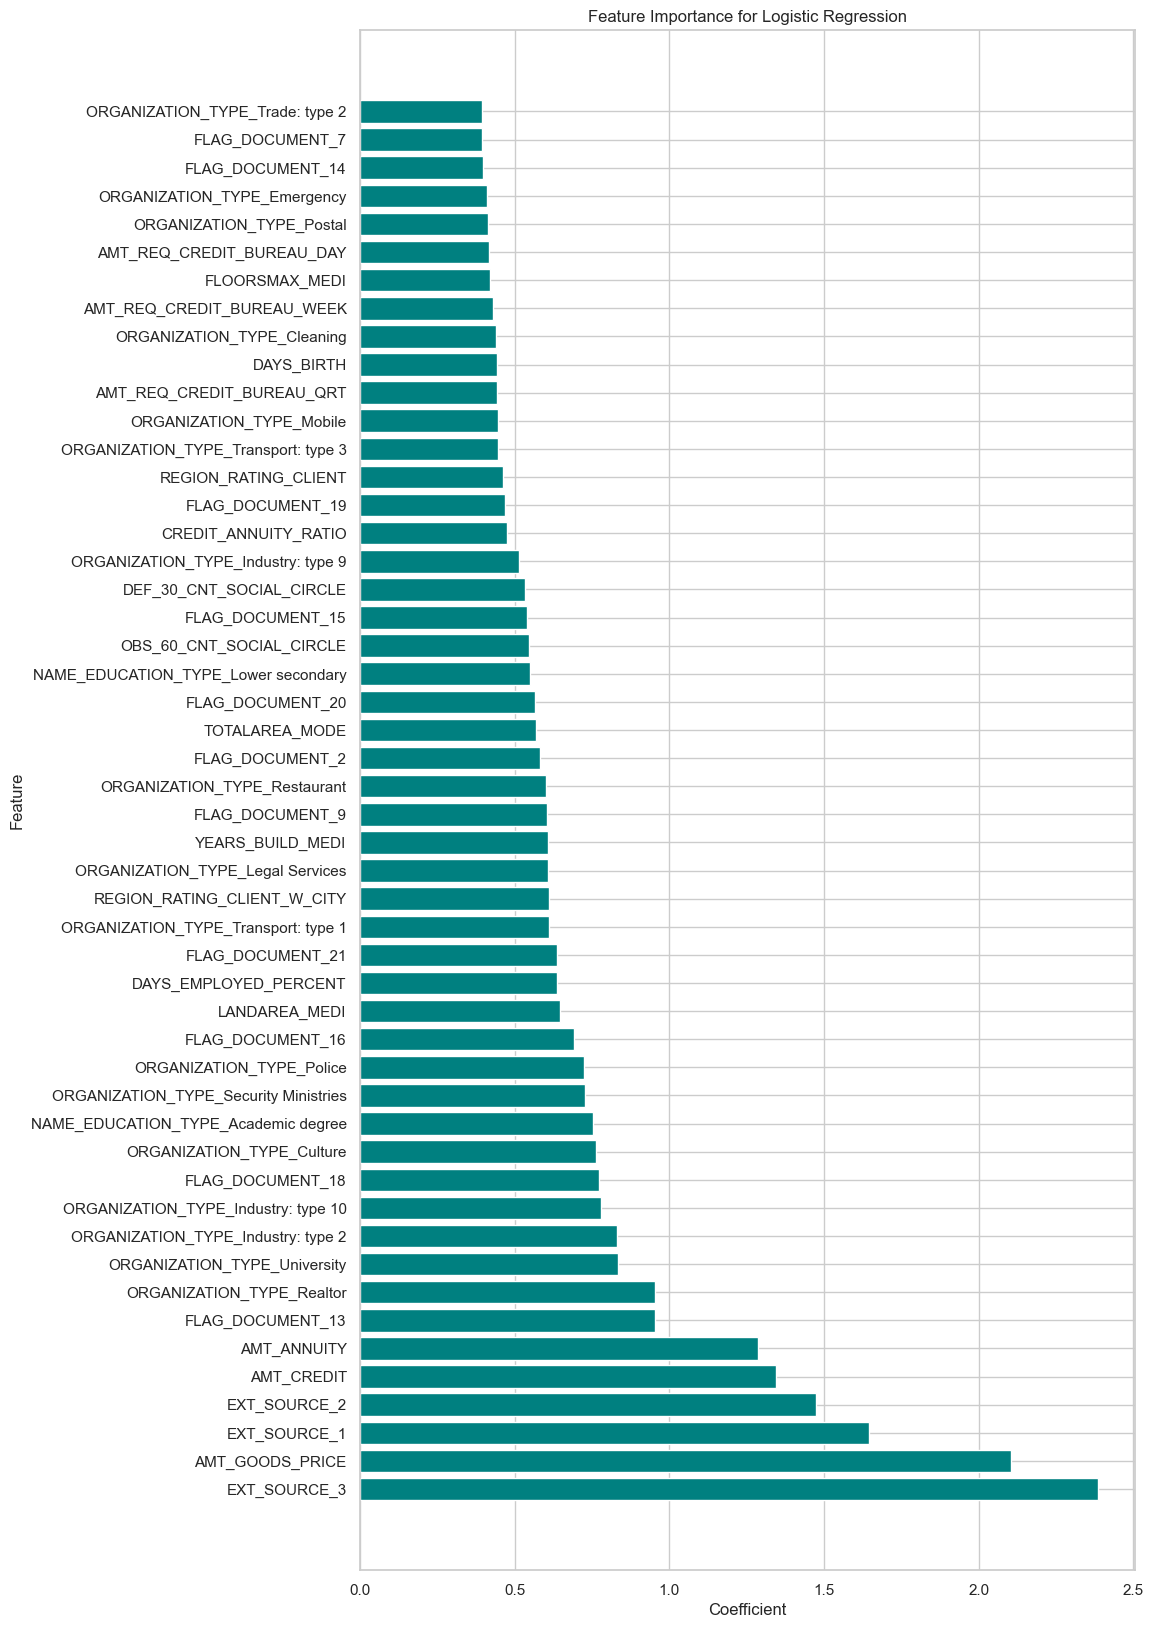

In [599]:
top_features = feature_importance.head(50)
# Plot the feature importance
plt.figure(figsize=(10, 20))
plt.barh(
    top_features["Feature"],
    top_features["Absolute Coefficient"],
    color="teal",
)
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Feature Importance for Logistic Regression")
plt.show()


In [600]:
def get_original_feature(feature):
    # print(f"Feature: {feature}")
    num_features = X_train.select_dtypes(exclude="object").columns
    if feature in num_features:
        # print("Is numerical")
        return feature
    else:
        feature_name = feature.split("__")[-1] if "__" in feature else feature
        for col in X_train.columns:
            if feature_name.startswith(col):
                # print(f"Found original : {col}")
                return col


In [601]:
feature_importance["Original Feature"] = feature_importance["Feature"].apply(get_original_feature)

lr_best_features = []
lr_top_features = []
for feature, coef in zip(feature_importance["Original Feature"], feature_importance["Absolute Coefficient"]):
    if coef > 0.5 and feature not in lr_best_features:
        lr_best_features.append(feature)
    if coef > 1.1 and feature not in lr_top_features:
        lr_top_features.append(feature)

print(len(lr_best_features))
print(f"Top features : {len(lr_top_features)}")

23
Top features : 6


In [602]:
rfc_pipeline.fit(X_train, y_train)
feature_names = rfc_pipeline.named_steps["preprocessor"].get_feature_names_out()
rfc_features = rfc_pipeline.named_steps["model"].feature_importances_

# Combine feature names and importances into a DataFrame
rfc_feature_importances = pd.DataFrame(
    {"Feature": feature_names, "Importance": rfc_features}
)

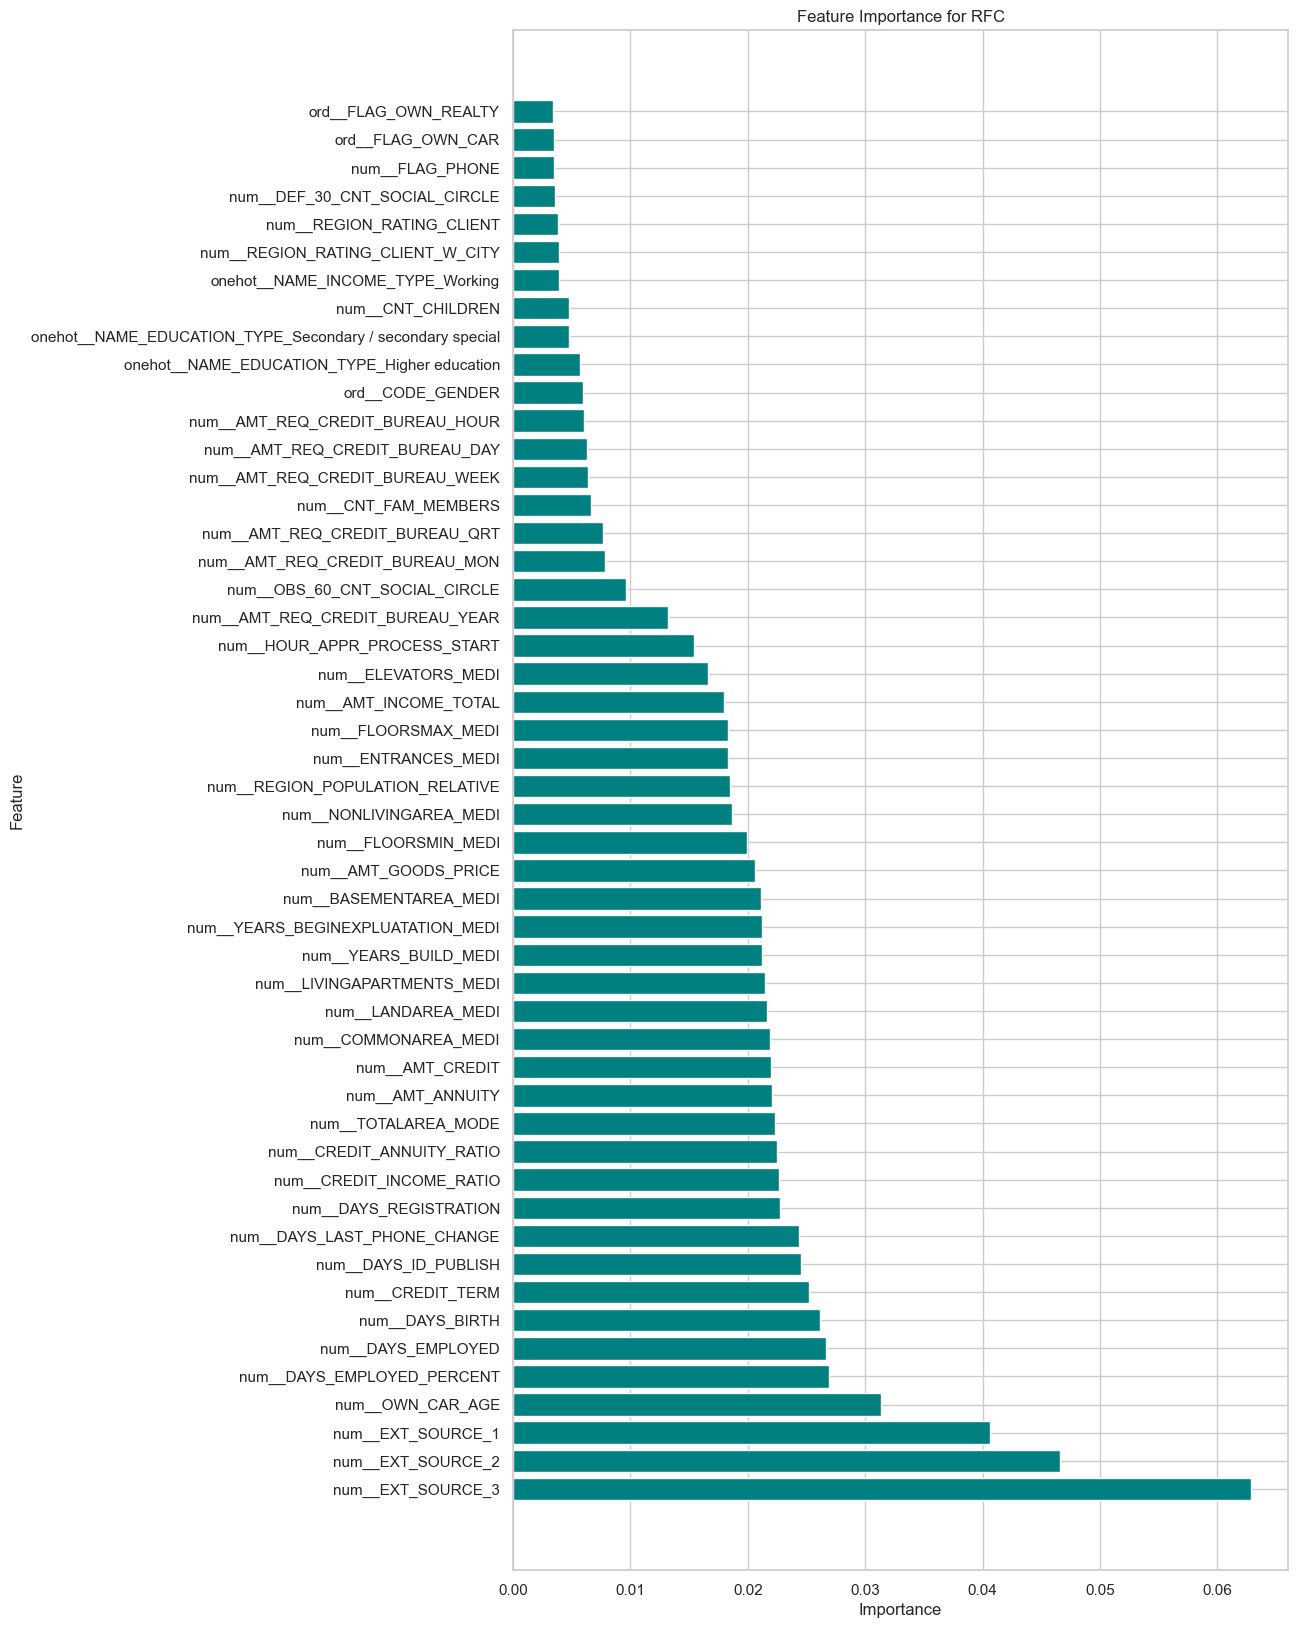

In [603]:
feature_importance["Original Feature"] = feature_importance["Feature"].apply(get_original_feature)
rfc_top_features = rfc_feature_importances.sort_values("Importance", ascending=False).head(50)
plt.figure(figsize=(10, 20))
plt.barh(
    rfc_top_features["Feature"],
    rfc_top_features["Importance"],
    color="teal",
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for RFC")
plt.show()

In [604]:
rfc_feature_importances["Original Feature"] = rfc_feature_importances["Feature"].apply(
    get_original_feature
)
# clean features name
rfc_best_features = []
rfc_top_features = []

for feature, coef in zip(rfc_feature_importances["Original Feature"], rfc_feature_importances["Importance"]):
    # print(f"feature: {feature} - coef: {coef}")
    if coef > 0.01 and feature not in rfc_best_features:
        rfc_best_features.append(feature)
    if coef > 0.02 and feature not in rfc_top_features:
        # print(f"Feature: {feature} - Importance: {coef}")
        rfc_top_features.append(feature)

print(len(rfc_best_features))
print(f"Top features : {len(rfc_top_features)}")

31
Top features : 22


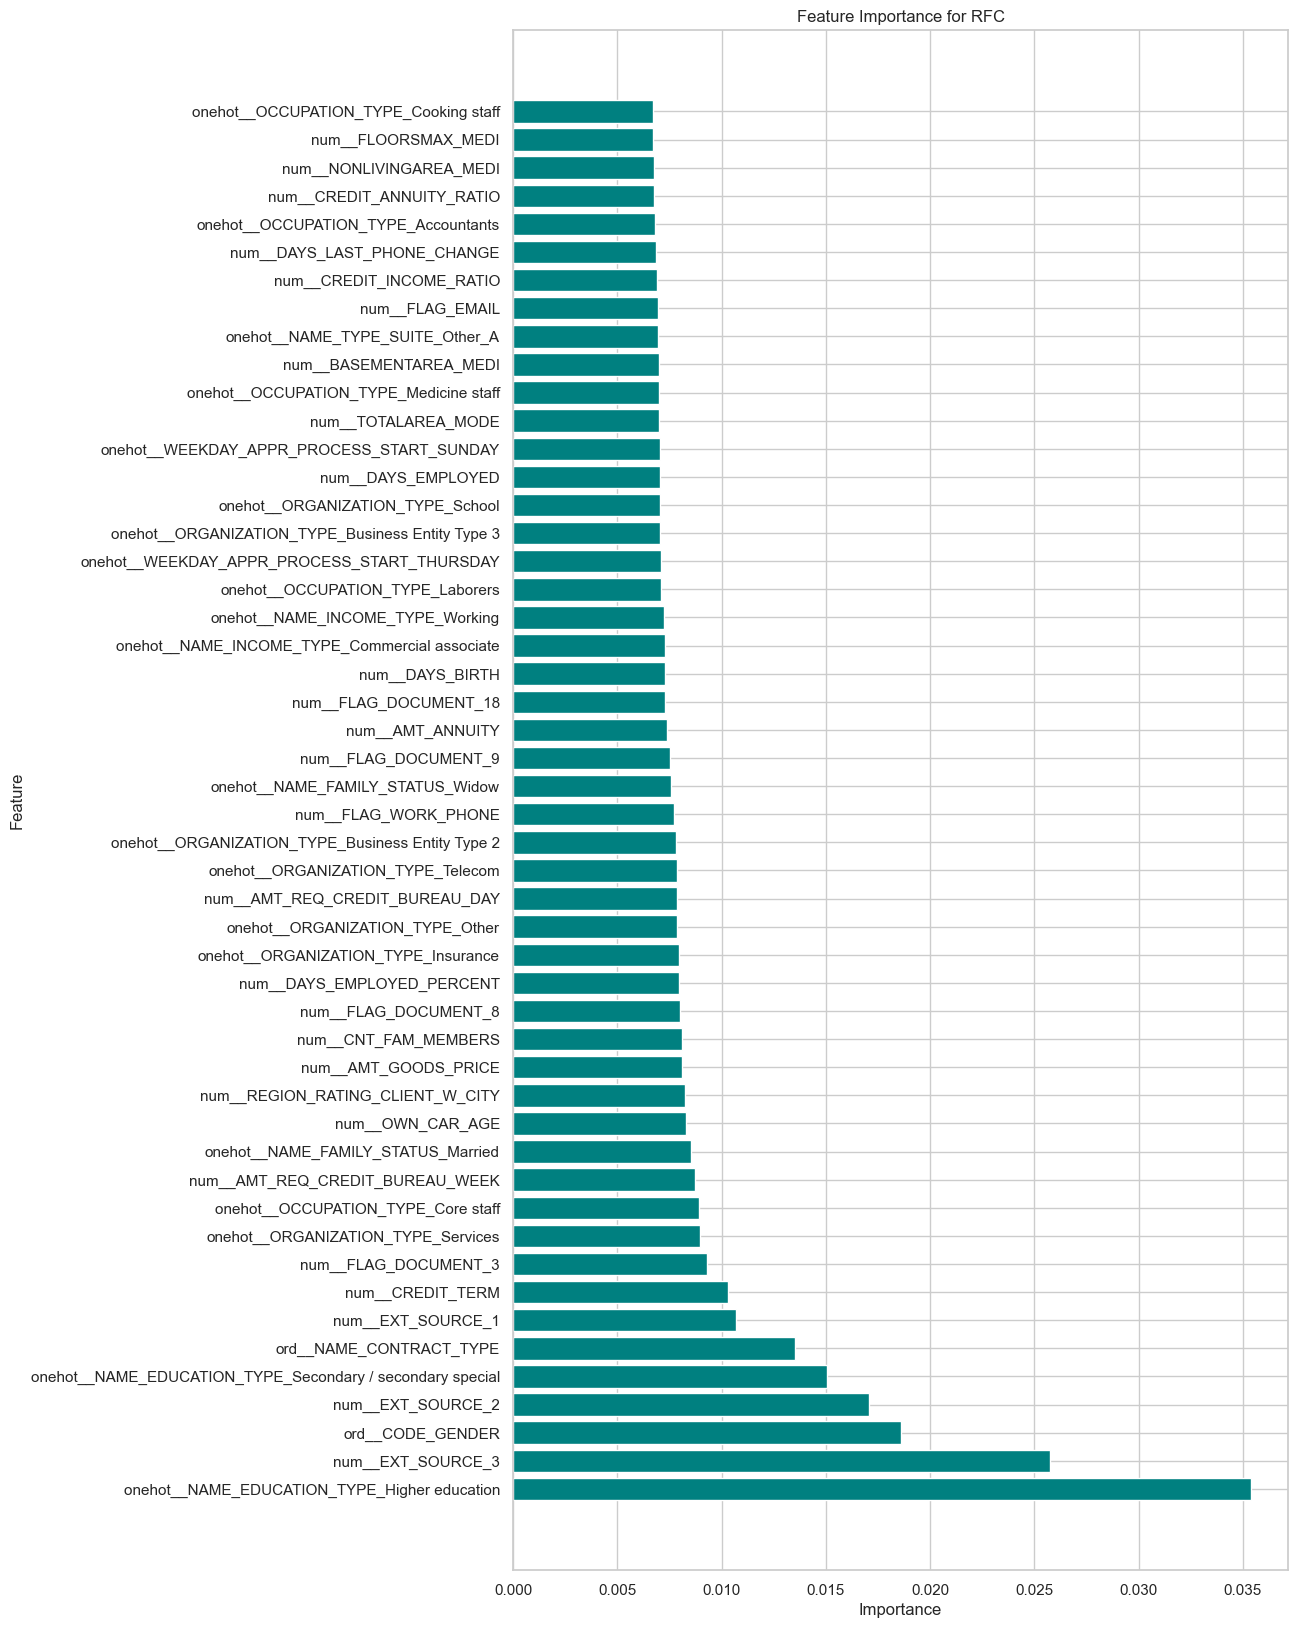

In [605]:
xgb_pipeline.fit(X_train, y_train)
feature_names = xgb_pipeline.named_steps["preprocessor"].get_feature_names_out()
xgb_features = xgb_pipeline.named_steps["model"].feature_importances_

# Combine feature names and importances into a DataFrame
xgb_feature_importances = pd.DataFrame(
    {"Feature": feature_names, "Importance": xgb_features}
)

xgb_top_features = xgb_feature_importances.sort_values(
    "Importance", ascending=False
).head(50)
plt.figure(figsize=(10, 20))
plt.barh(
    xgb_top_features["Feature"],
    xgb_top_features["Importance"],
    color="teal",
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for RFC")
plt.show()

In [606]:
xgb_feature_importances["Original Feature"] = xgb_feature_importances["Feature"].apply(
    get_original_feature
)
xgb_best_features = []
xgb_top_features = []
for feature, coef in zip(
    xgb_feature_importances["Original Feature"], xgb_feature_importances["Importance"]
):
    if coef > 0.008:
        xgb_best_features.append(feature)
    if coef > 0.01:
        xgb_top_features.append(feature)

print(len(xgb_best_features))
print(f"Top features : {len(xgb_top_features)}")

18
Top features : 8


[LightGBM] [Info] Number of positive: 5213, number of negative: 59363
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9478
[LightGBM] [Info] Number of data points in the train set: 64576, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080727 -> initscore=-2.432516
[LightGBM] [Info] Start training from score -2.432516


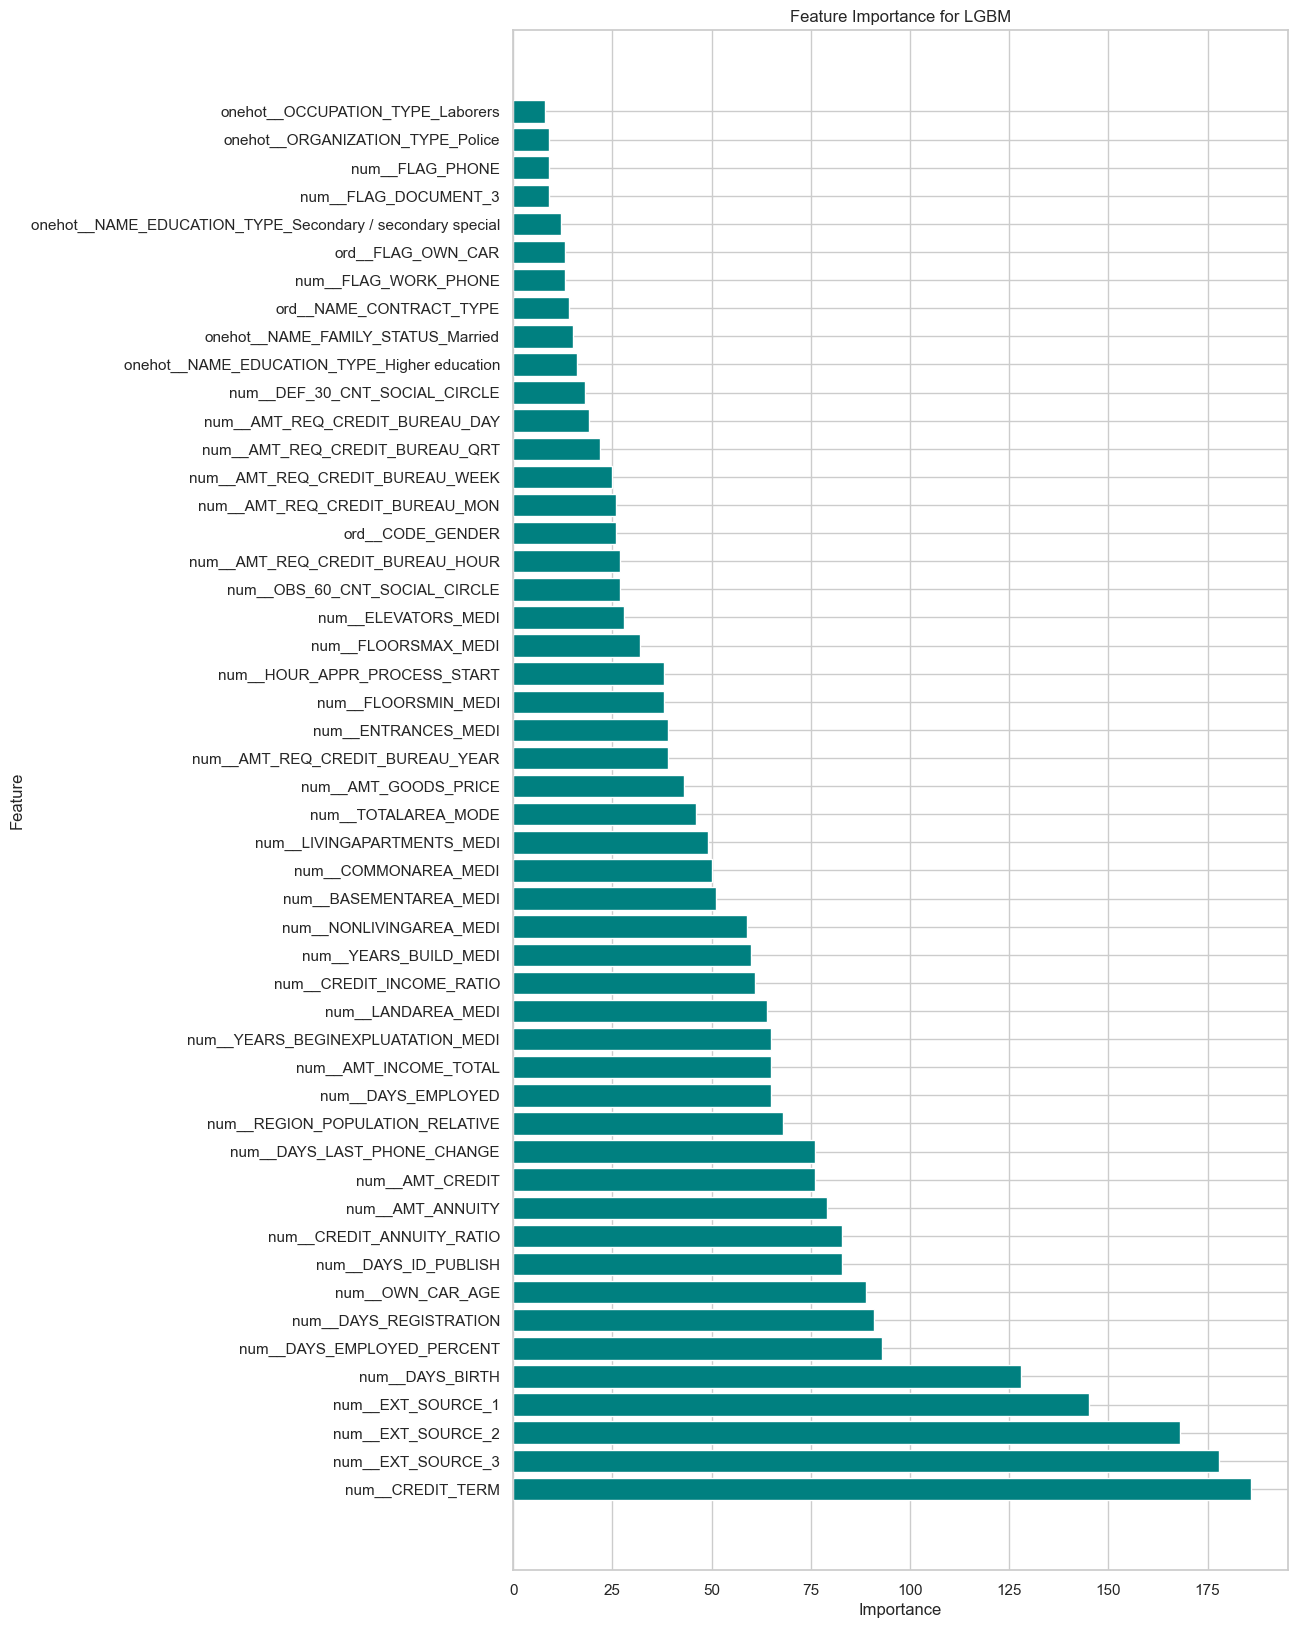

In [607]:
lgbm_pipeline.fit(X_train, y_train)
feature_names = lgbm_pipeline.named_steps["preprocessor"].get_feature_names_out()
lgbm_features = lgbm_pipeline.named_steps["model"].feature_importances_

# Combine feature names and importances into a DataFrame
lgbm_feature_importances = pd.DataFrame(
    {"Feature": feature_names, "Importance": lgbm_features}
)

lgbm_top_features = lgbm_feature_importances.sort_values(
    "Importance", ascending=False
).head(50)
plt.figure(figsize=(10, 20))
plt.barh(
    lgbm_top_features["Feature"],
    lgbm_top_features["Importance"],
    color="teal",
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for LGBM")
plt.show()


In [608]:
lgbm_feature_importances["Original Feature"] = lgbm_feature_importances[
    "Feature"
].apply(get_original_feature)

lgbm_best_features = []
lgbm_top_features = []
for feature, coef in zip(
    lgbm_feature_importances["Original Feature"], lgbm_feature_importances["Importance"]
):
    if coef >= 25:
        lgbm_best_features.append(feature)
    if coef >= 75:
        lgbm_top_features.append(feature)

print(len(lgbm_best_features))
print(f"Top features : {len(lgbm_top_features)}")

37
Top features : 13


In [609]:
# get all top features
top_features = list(set(lr_top_features + rfc_top_features + xgb_top_features + lgbm_top_features))
print(f"Total top features : {len(top_features)}")

# get all best features
best_features = list(set(lr_best_features + rfc_best_features + xgb_best_features + lgbm_best_features))
print(f"Total best features : {len(best_features)}")

Total top features : 25
Total best features : 56


## Test models on top features

In [611]:
X_train_top_selection = X_train[top_features]
print(f"shape : {X_train_top_selection.shape}")
preprocessor, cat_col = make_col_processor(X_train_top_selection)

lr_pipeline_top = create_pipeline(lr, preprocessor, rus)
rfc_pipeline_top = create_pipeline(rfc, preprocessor, rus)
xgb_pipeline_top = create_pipeline(xgb, preprocessor)
smote_lgbm_pipeline_top = create_pipeline(lgbm, preprocessor, smote)
lgbm_pipeline_top = create_pipeline(lgbm, preprocessor)

pipelines_top = [lr_pipeline_top, rfc_pipeline_top, xgb_pipeline_top, smote_lgbm_pipeline_top, lgbm_pipeline_top]

shape : (64576, 25)
2 columns to process with a label encoder.
['NAME_CONTRACT_TYPE', 'CODE_GENDER']
1 columns to process with a one-hot encoder.
['NAME_EDUCATION_TYPE']


In [612]:
top_features_results = pd.DataFrame()

for pipeline in pipelines_top:
    top_features_results = evaluate_model_cv(X_train_top_selection, y_train, pipeline, n_splits=5, results=top_features_results)

display(top_features_results)

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 a

[LightGBM] [Info] Number of positive: 47490, number of negative: 47490
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5641
[LightGBM] [Info] Number of data points in the train set: 94980, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 47490, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5649
[LightGBM] [Info] Number of data points in the train set: 94980, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 47490, number of neg

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4170, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 51660, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080720 -> initscore=-2.432603
[LightGBM] [Info] Start training from score -2.432603
[LightGBM] [Info] Number of positive: 4171, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5612
[LightGBM] [Info] Number of data points in the train set: 51661, number of used features: 29
[LightGBM] [Info] [b

,Model,Strategy,Time,Accuracy_train,Accuracy_test,Recall_train,Recall_test,f2_train,f2_test,ROC_AUC_train,ROC_AUC_test,Custom_train,Custom_test
0,LogisticRegression,RandomUnderSampler,0.949904,0.682537,0.682421,0.671974,0.668906,0.405951,0.404304,0.739771,0.738341,0.170033,0.168262
1,RandomForestClassifier,RandomUnderSampler,2.871665,0.739485,0.685471,1.000000,0.654709,0.607767,0.398962,0.986397,0.728807,1.000000,0.159450
2,XGBClassifier,None,1.148601,0.879843,0.804788,0.965423,0.425476,0.751989,0.339316,0.971774,0.706138,0.736684,0.068990
3,LGBMClassifier,SMOTE,1.750868,0.424209,0.403803,0.958661,0.857857,0.397803,0.354448,0.784162,0.697545,0.698825,0.377426
4,LGBMClassifier,None,1.452222,0.772950,0.738835,0.847400,0.595817,0.564384,0.401095,0.887205,0.740416,0.357202,0.128620


### Test models on best features

In [613]:
X_train_best_selection = X_train[best_features]
X_test_best_selection = X_test[best_features]
print(f"shape : {X_train_best_selection.shape}")
preprocessor, cat_col = make_col_processor(X_train_best_selection)

lr_pipeline_best = create_pipeline(lr, preprocessor, rus)
rfc_pipeline_best = create_pipeline(rfc, preprocessor, rus)
xgb_pipeline_best = create_pipeline(xgb, preprocessor)
smote_lgbm_pipeline_best = create_pipeline(lgbm, preprocessor, smote)
lgbm_pipeline_best = create_pipeline(lgbm, preprocessor)

pipelines_best = [lr_pipeline_best, rfc_pipeline_best, xgb_pipeline_best, smote_lgbm_pipeline_best, lgbm_pipeline_best]

shape : (64576, 56)
2 columns to process with a label encoder.
['NAME_CONTRACT_TYPE', 'CODE_GENDER']
4 columns to process with a one-hot encoder.
['NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE']


In [614]:
best_features_results = pd.DataFrame()

for pipeline in pipelines_best:
    best_features_results = evaluate_model_cv(
        X_train_best_selection,
        y_train,
        pipeline,
        n_splits=5,
        results=best_features_results,
    )

display(best_features_results)


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 a

[LightGBM] [Info] Number of positive: 47490, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22815
[LightGBM] [Info] Number of data points in the train set: 94980, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 47490, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22276
[LightGBM] [Info] Number of data points in the train set: 94980, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4170, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8758
[LightGBM] [Info] Number of data points in the train set: 51660, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080720 -> initscore=-2.432603
[LightGBM] [Info] Start training from score -2.432603
[LightGBM] [Info] Number of positive: 4171, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8769
[LightGBM] [Info] Number of data points in the train set: 51661, number of used features: 131
[LightGBM] [Info] 

,Model,Strategy,Time,Accuracy_train,Accuracy_test,Recall_train,Recall_test,f2_train,f2_test,ROC_AUC_train,ROC_AUC_test,Custom_train,Custom_test
0,LogisticRegression,RandomUnderSampler,6.339707,0.682657,0.680686,0.679647,0.672934,0.409902,0.405303,0.745896,0.738607,0.175038,0.170827
1,RandomForestClassifier,RandomUnderSampler,7.861973,0.737546,0.686524,1.000000,0.646653,0.606019,0.395428,0.991218,0.726365,1.000000,0.155051
2,XGBClassifier,None,6.860685,0.889018,0.809542,0.970986,0.412433,0.768600,0.333438,0.975843,0.705063,0.770516,0.065688
3,LGBMClassifier,SMOTE,7.550979,0.667833,0.643366,0.837185,0.702667,0.476261,0.398164,0.824236,0.730912,0.339775,0.191751
4,LGBMClassifier,None,6.936551,0.780820,0.741158,0.855458,0.585844,0.575996,0.397000,0.896099,0.739419,0.371848,0.124002


## Hypertuning

In [618]:
preprocessor, categorical_columns = make_col_processor(X_train_top_selection)

2 columns to process with a label encoder.
['NAME_CONTRACT_TYPE', 'CODE_GENDER']
1 columns to process with a one-hot encoder.
['NAME_EDUCATION_TYPE']


In [619]:
# Define multiple scoring metrics
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "recall": make_scorer(recall_score),
    "roc_auc": make_scorer(roc_auc_score, needs_proba=True),
    "f2_score": make_scorer(fbeta_score, beta=2),
    "business": make_scorer(cost_score, greater_is_better=True),
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [626]:
lr = LogisticRegression(
    class_weight= "balanced",
    max_iter=100,
    solver="liblinear",
    penalty="l1"
)

lr_pipeline = create_pipeline(lr, preprocessor, rus)

lr_param_grid = {
    # "model__solver": ["newton-cholesky", "liblinear", "saga"],
    # "model__penalty": ["l2", "l1"],
    # "model__class_weight": ["balanced", None], # consider class_weight="balanced"
    "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
    # "model__max_iter": [100, 200], # Control the number of iterations
}
grid_search = GridSearchCV(
    estimator=lr_pipeline, param_grid=lr_param_grid, cv=skf, scoring=scoring, refit="f2_score"
)

grid_search.fit(X_train_top_selection, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

# Access the scores for all metrics
results = grid_search.cv_results_
print("Mean test scores for each metric:")
for scorer in scoring.keys():
    print(f"{scorer}: {results[f'mean_test_{scorer}']}")

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters found:  {'model__C': 10}
Best recall score:  0.4064003471898004
Mean test scores for each metric:
accuracy: [0.91927341 0.69765842 0.68212636 0.68046941 0.68234327 0.68328789]
recall: [0.         0.62114471 0.66353627 0.66986693 0.67312657 0.66948232]
roc_auc: [0.5        0.72278273 0.73633097 0.73867732 0.7400807  0.73998604]
f2_score: [0.         0.38880717 0.40141012 0.40361393 0.40640035 0.40510462]
business: [0.         0.14106162 0.16498963 0.16889863 0.17091223 0.16876247]


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [616]:
def get_best_params(pipeline, param_grid, X, y, scoring, cv):

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        refit="f2_score",
    )

    grid_search.fit(X, y)

    # Print the best parameters and the best score
    print("Best parameters found: ", grid_search.best_params_)
    print("Best accuracy score: ", grid_search.best_score_)

    # Access the scores for all metrics
    results = grid_search.cv_results_
    print("Mean test scores for each metric:")
    for scorer in scoring.keys():
        print(f"{scorer}: {results[f'mean_test_{scorer}']}")

    return grid_search.best_params_, grid_search.best_score_


In [627]:
hypertuned_results = pd.DataFrame()
lr = LogisticRegression(
    C=10, class_weight="balanced", max_iter=100, solver="liblinear", penalty="l1"
)
lr_best_pipeline = create_pipeline(
    lr,
    preprocessor,
    rus,
)

hypertuned_results = evaluate_model_cv(X_train_top_selection, y_train, lr_best_pipeline, n_splits=5, results=hypertuned_results)

display(hypertuned_results)

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


,Model,Strategy,Time,Accuracy_train,Accuracy_test,Recall_train,Recall_test,f2_train,f2_test,ROC_AUC_train,ROC_AUC_test,Custom_train,Custom_test
0,LogisticRegression,RandomUnderSampler,5.611059,0.682738,0.682808,0.673892,0.671785,0.407044,0.406008,0.741661,0.739184,0.171273,0.170074


#### RFC

In [635]:
rfc = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=4,
    bootstrap=False,
    criterion="gini",
    max_features="sqrt",
)
rfc_grid_pipeline = create_pipeline(rfc, preprocessor,rus)

param_grid = {
    # "model__n_estimators": [100, 200, 300],  # Number of trees in random forest
    # 'model__max_depth': [20, 30, 40], # Maximum depth of the tree
    # 'model__min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    # 'model__min_samples_leaf': [1, 2, 4], # Minimum number of samples required to be at a leaf node
    # 'model__max_features': [None, 'sqrt', 'log2'], # Number of features to consider at every split
    # 'model__bootstrap': [True, False], # Method of selecting samples for training each tree
    # 'model__criterion': ['gini', 'entropy', 'log_loss'] # The function to measure the quality of a split
    # 'model__class_weight': ['balanced', None, {0:1, 1:10}], # Weights associated with classes
}

get_best_params(rfc_grid_pipeline, param_grid, X_train_top_selection, y_train, scoring, skf)

Best parameters found:  {'model__class_weight': 'balanced'}
Best accuracy score:  0.08570617216728062
Mean test scores for each metric:
accuracy: [0.91419413 0.91944376 0.91495293]
recall: [0.0721264  0.00594697 0.06119289]
roc_auc: [0.73002597 0.72534576 0.72842905]
f2_score: [0.08570617 0.0074145  0.0732653 ]
business: [0.00771911 0.00059815 0.0064769 ]


({'model__class_weight': 'balanced'}, np.float64(0.08570617216728062))

In [628]:
rfc = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=4,
    bootstrap=False,
    criterion="gini",
    max_features="sqrt",
)

rfc_best_pipeline = create_pipeline(rfc, preprocessor, rus)
hypertuned_results = evaluate_model_cv(X_train_top_selection, y_train, rfc_best_pipeline, n_splits=5, results=hypertuned_results)

display(hypertuned_results)

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


,Model,Strategy,Time,Accuracy_train,Accuracy_test,Recall_train,Recall_test,f2_train,f2_test,ROC_AUC_train,ROC_AUC_test,Custom_train,Custom_test
0,LogisticRegression,RandomUnderSampler,5.611059,0.682738,0.682808,0.673892,0.671785,0.407044,0.406008,0.741661,0.739184,0.171273,0.170074
1,RandomForestClassifier,RandomUnderSampler,23.148911,0.733132,0.681538,1.000000,0.671019,0.602022,0.404818,0.982396,0.735773,1.000000,0.169906


#### XGboost

In [525]:
xgb = XGBClassifier(
    scale_pos_weight=ratio,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=5,
    subsample=1,
    colsample_bytree=1,
    gamma=0,
    alpha=0.01,
    reg_lambda=0.1
    )

xgb_pipeline = create_pipeline(xgb, preprocessor)

param_grid = {
    # "model__n_estimators": [100,200,300],  # Controls the number of trees in the model. More trees can improve performance but also increase training time.
    # "model__learning_rate": [0.1, 1, 10], # Controls the contribution of each tree to the final prediction. Lower values can prevent overfitting.
    # "model__max_depth": [3, 5, 7], # Controls the maximum depth of each tree. Deeper trees can model more complex relationships but are more likely to overfit.
    # "model__min_child_weight": [5,8,10], # Controls the minimum number of samples in each leaf. Larger values can prevent overfitting.
    # "model__subsample": [0.6, 0.8, 1.0], # Controls the fraction of samples used in each boosting round. Lower values can prevent overfitting.
    # "model__colsample_bytree": [0.6, 0.8, 1.0], # Controls the fraction of features used in each boosting round. Lower values can prevent overfitting.
    # "model__gamma": [0, 0.1, 0.2], # Controls the minimum reduction in loss required to make a further partition on a leaf node of the tree. Larger values can prevent overfitting.
    "model__reg_alpha": [0, 0.01, 0.1], # Controls the L1 regularization term on the weights. Larger values can prevent overfitting.
    "model__reg_lambda": [0, 0.01, 0.1], # Controls the L2 regularization term on the weights. Larger values can prevent overfitting.
}

get_best_params(xgb_pipeline, param_grid, X_train_top_selection, y_train, scoring, skf)

Best parameters found:  {'model__reg_alpha': 0.01, 'model__reg_lambda': 0.1}
Best accuracy score:  0.4151610849830217
Mean test scores for each metric:
accuracy: [0.70193256 0.70191708 0.7026139  0.70190159 0.70196353 0.70247453
 0.70213388 0.70176225 0.70273781]
recall: [0.66391702 0.6643009  0.66506755 0.66449283 0.66430108 0.66564336
 0.66180827 0.66334231 0.66430255]
roc_auc: [0.74761331 0.74753716 0.74761796 0.74737791 0.74739778 0.7477816
 0.74737863 0.7474747  0.74777215]
f2_score: [0.41391516 0.41410285 0.4149536  0.41419287 0.41413279 0.41516108
 0.41293618 0.41349799 0.41461784]
business: [0.16500067 0.16524622 0.16574225 0.16536108 0.16524218 0.16611463
 0.16372542 0.16466659 0.16533617]


({'model__reg_alpha': 0.01, 'model__reg_lambda': 0.1},
 np.float64(0.4151610849830217))

In [636]:
xgb = XGBClassifier(
    scale_pos_weight=ratio,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=5,
    subsample=1,
    colsample_bytree=1,
    gamma=0,
    alpha=0.01,
    reg_lambda=0.1,
)

xgb_best_pipeline = create_pipeline(xgb, preprocessor)
hypertuned_results = evaluate_model_cv(
    X_train_top_selection,
    y_train,
    xgb_best_pipeline,
    n_splits=5,
    results=hypertuned_results,
)

display(hypertuned_results)


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


,Model,Strategy,Time,Accuracy_train,Accuracy_test,Recall_train,Recall_test,f2_train,f2_test,ROC_AUC_train,ROC_AUC_test,Custom_train,Custom_test
0,LogisticRegression,RandomUnderSampler,5.611059,0.682738,0.682808,0.673892,0.671785,0.407044,0.406008,0.741661,0.739184,0.171273,0.170074
1,RandomForestClassifier,RandomUnderSampler,23.148911,0.733132,0.681538,1.000000,0.671019,0.602022,0.404818,0.982396,0.735773,1.000000,0.169906
2,XGBClassifier,None,1.081304,0.709010,0.702180,0.710771,0.662575,0.442786,0.413371,0.781811,0.746967,0.197275,0.164214


In [643]:
lgbm = LGBMClassifier(
    scale_pos_weight=ratio,
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    num_leaves=31,
    min_child_samples= 10,
    subsample=0.6,
    colsample_bytree=1,
    reg_alpha=0.01,
    reg_lambda=0.1,
    min_split_gain=0,
    min_data_in_leaf=40,
)
lgbm_pipeline = create_pipeline(lgbm, preprocessor)

lgbm_param_grid = {
    # "model__n_estimators": [100, 200, 300], # Controls the number of trees in the model. More trees can improve performance but also increase training time.
    # "model__learning_rate": [0.01, 0.05, 0.1], # Controls the contribution of each tree to the final prediction. Lower values can prevent overfitting.
    # "model__max_depth": [3, 5, 7], # Controls the maximum depth of each tree. Deeper trees can model more complex relationships but are more likely to overfit.
    # "model__num_leaves": [31, 63, 127], # Controls the maximum number of leaves in each tree. Larger values can model more complex relationships but are more likely to overfit.
    "model__min_child_samples": [10, 20, 30],# Controls the minimum number of samples in each leaf. Larger values can prevent overfitting.
    # "model__subsample": [0.6, 0.8, 1.0], # Controls the fraction of samples used in each boosting round. Lower values can prevent overfitting.
    # "model__colsample_bytree": [0.6, 0.8, 1.0], # Controls the fraction of features used in each boosting round. Lower values can prevent overfitting.
    # "model__reg_alpha": [0, 0.01, 0.1], # Controls the L1 regularization term on the weights. Larger values can prevent overfitting.
    # "model__reg_lambda": [0, 0.01, 0.1], # Controls the L2 regularization term on the weights. Larger values can prevent overfitting.
    # "model__min_split_gain": [0, 0.1, 0.2], # Controls the minimum reduction in loss required to make a further partition on a leaf node of the tree. Larger values can prevent overfitting.
    # "model__min_data_in_leaf": [40, 50, 60]  # [20, 30, 40],
    # 'model__min_gain_to_split': [0, 0.1, 0.2],
}

get_best_params(lgbm_pipeline, lgbm_param_grid, X_train_top_selection, y_train, scoring, skf)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Number of positive: 4170, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 51660, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080720 -> initscore=-2.432603
[LightGBM] [Info] Start training from score -2.432603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

({'model__min_child_samples': 10}, np.float64(0.4112277737527026))

In [644]:
lgbm = LGBMClassifier(
    scale_pos_weight=ratio,
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    num_leaves=31,
    min_child_samples=10,
    subsample=0.6,
    colsample_bytree=1,
    reg_alpha=0.01,
    reg_lambda=0.1,
    min_split_gain=0,
    min_data_in_leaf=40,
)
lgbm_pipeline = create_pipeline(lgbm, preprocessor)

hypertuned_results = evaluate_model_cv(
    X_train_top_selection,
    y_train,
    lgbm_pipeline,
    n_splits=5,
    results=hypertuned_results,
)
display(hypertuned_results)

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Number of positive: 4170, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 51660, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080720 -> initscore=-2.432603
[LightGBM] [Info] Start training from score -2.432603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

,Model,Strategy,Time,Accuracy_train,Accuracy_test,Recall_train,Recall_test,f2_train,f2_test,ROC_AUC_train,ROC_AUC_test,Custom_train,Custom_test
0,LogisticRegression,RandomUnderSampler,5.611059,0.682738,0.682808,0.673892,0.671785,0.407044,0.406008,0.741661,0.739184,0.171273,0.170074
1,RandomForestClassifier,RandomUnderSampler,23.148911,0.733132,0.681538,1.000000,0.671019,0.602022,0.404818,0.982396,0.735773,1.000000,0.169906
2,XGBClassifier,None,1.081304,0.709010,0.702180,0.710771,0.662575,0.442786,0.413371,0.781811,0.746967,0.197275,0.164214
3,LGBMClassifier,None,1.376402,0.730360,0.715498,0.744197,0.642242,0.475305,0.411228,0.817938,0.744501,0.225431,0.152365


In [645]:
preprocessor, cat_col = make_col_processor(X_train_top_selection)
best_processor, best_cat_col = make_col_processor(X_train_best_selection)

lr_grid_pipeline = create_pipeline(lr,best_processor,rus)
rfc_grid_pipeline = create_pipeline(rfc, best_processor, rus)
xgb_pipeline = create_pipeline(xgb, best_processor)
lgbm_pipeline = create_pipeline(lgbm, best_processor)
all_pipepline = [lr_grid_pipeline, rfc_grid_pipeline, xgb_pipeline, lgbm_pipeline]

2 columns to process with a label encoder.
['NAME_CONTRACT_TYPE', 'CODE_GENDER']
1 columns to process with a one-hot encoder.
['NAME_EDUCATION_TYPE']
2 columns to process with a label encoder.
['NAME_CONTRACT_TYPE', 'CODE_GENDER']
4 columns to process with a one-hot encoder.
['NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE']


In [646]:
for pipe in all_pipepline:
    hypertuned_results = evaluate_model_cv(X_train_best_selection, y_train, pipe, n_splits=5, results=hypertuned_results)

display(hypertuned_results)

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 a

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Number of positive: 4170, number of negative: 47490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8748
[LightGBM] [Info] Number of data points in the train set: 51660, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080720 -> initscore=-2.432603
[LightGBM] [Info] Start training from score -2.432603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

,Model,Strategy,Time,Accuracy_train,Accuracy_test,Recall_train,Recall_test,f2_train,f2_test,ROC_AUC_train,ROC_AUC_test,Custom_train,Custom_test
0,LogisticRegression,RandomUnderSampler,5.611059,0.682738,0.682808,0.673892,0.671785,0.407044,0.406008,0.741661,0.739184,0.171273,0.170074
1,RandomForestClassifier,RandomUnderSampler,23.148911,0.733132,0.681538,1.000000,0.671019,0.602022,0.404818,0.982396,0.735773,1.000000,0.169906
2,XGBClassifier,None,1.081304,0.709010,0.702180,0.710771,0.662575,0.442786,0.413371,0.781811,0.746967,0.197275,0.164214
3,LGBMClassifier,None,1.376402,0.730360,0.715498,0.744197,0.642242,0.475305,0.411228,0.817938,0.744501,0.225431,0.152365
4,LogisticRegression,RandomUnderSampler,16.506652,0.682607,0.680717,0.683723,0.670058,0.411927,0.403864,0.747173,0.737478,0.177770,0.169036
5,RandomForestClassifier,RandomUnderSampler,11.135328,0.735622,0.683102,1.000000,0.670442,0.604251,0.405476,0.982590,0.735018,1.000000,0.169489
6,XGBClassifier,None,6.913545,0.711437,0.702738,0.713073,0.657972,0.445630,0.411311,0.785490,0.747433,0.199083,0.161469
7,LGBMClassifier,None,7.244619,0.734975,0.717480,0.750048,0.636871,0.481847,0.409629,0.823840,0.744312,0.230899,0.149367


## treshold test

In [648]:
lr_grid_pipeline = create_pipeline(lr, preprocessor, rus)
rfc_grid_pipeline = create_pipeline(rfc, preprocessor, rus)
xgb_pipeline = create_pipeline(xgb, preprocessor)
lgbm_pipeline = create_pipeline(lgbm, preprocessor)
all_pipepline = [lr_grid_pipeline, rfc_grid_pipeline, xgb_pipeline, lgbm_pipeline]

After defining the hyperparameter for our 2 models, let's give a look at the decision treshold. The decision treshold defines the probability from which the model should considerate that a client is risky or not. Usually, this treshold is set at 0.5 (if the probability that a client is dangerous is lesser than 0.5, then the model should considerate him as a safe client, and vice versa.)

In [649]:
from sklearn.metrics import precision_score
# X_test_best_selection = X_test[best_features]
X_test_top_selection = X_test[top_features]
# Fit the pipeline
xgb_pipeline.fit(X_train_top_selection, y_train)

# predict probabilities on the positive class
y_prob = xgb_pipeline.predict_proba(X_test_top_selection)[:, 1]

# Tresholds to test
thresholds = [i / 100 for i in range(5, 100, 5)]

# Initialize lists to store performance metrics
accuracy_list = []
recall_list = []
custom_recall = []
f2_list = []

# Calculate ROC curve and AUC score
roc_auc = roc_auc_score(y_test, y_prob)

for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    accuracy_list.append(accuracy_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    custom_recall.append(cost_score(y_test, y_pred))
    f2_list.append(fbeta_score(y_test, y_pred, beta=2))

# Create a DataFrame to store the results
results_df = pd.DataFrame(
    {
        "Threshold": thresholds,
        "Accuracy": accuracy_list,
        "Recall": recall_list,
        "Custom Score": custom_recall,
        "F2": f2_list,
    }
)

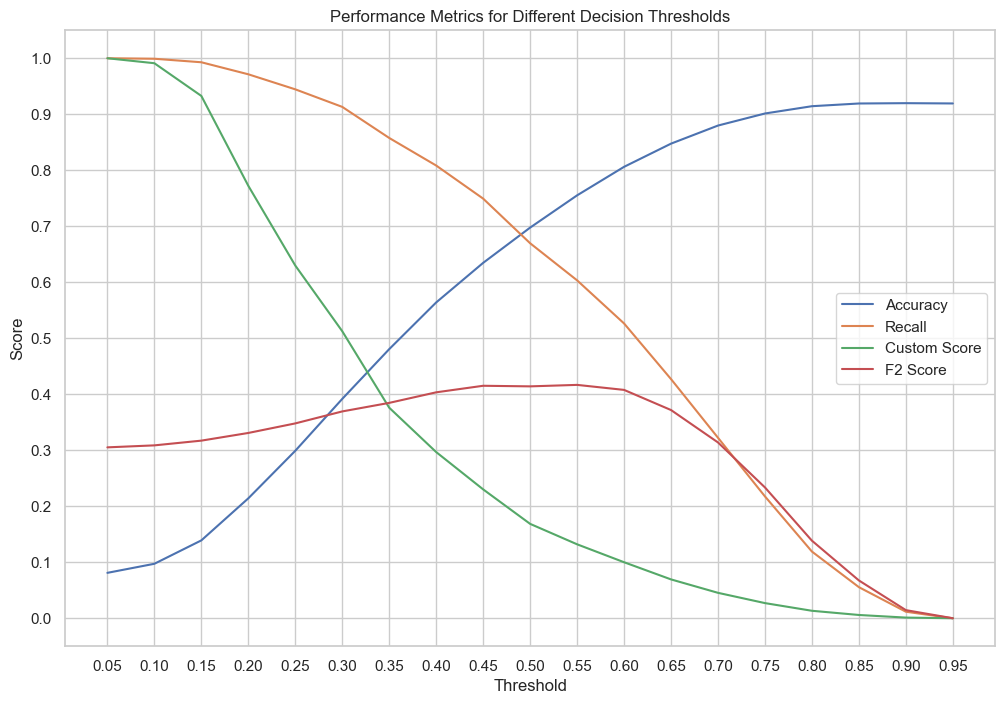

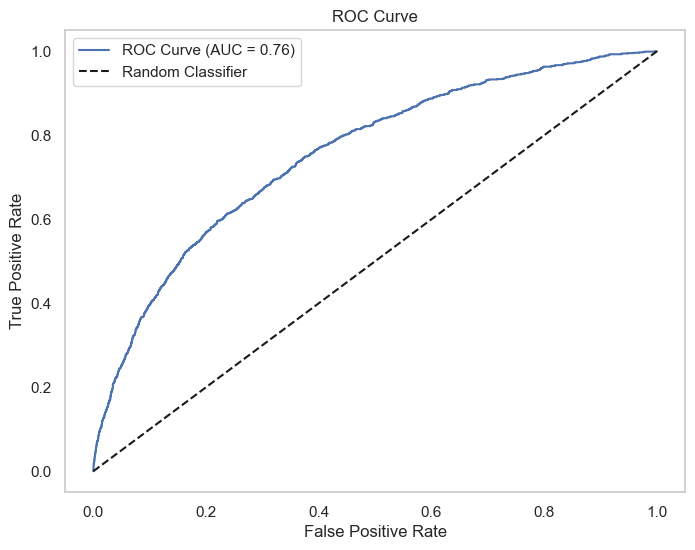

In [650]:
# Plotting the performance metrics
plt.figure(figsize=(12, 8))
plt.title(
    "Performance Metrics for Different Decision Thresholds for XGBClassifier"
)
plt.plot(results_df["Threshold"], results_df["Accuracy"], label="Accuracy")
plt.plot(results_df["Threshold"], results_df["Recall"], label="Recall")
plt.plot(results_df["Threshold"], results_df["Custom Score"], label="Custom Score")
plt.plot(results_df["Threshold"], results_df["F2"], label="F2 Score")
plt.xlabel("Threshold")
plt.xticks(thresholds)
plt.ylabel("Score")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Performance Metrics for Different Decision Thresholds")
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


# PART4: UNDERSTAND THE RESULTS

##  Local features

In [550]:
import shap

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### XGBoost

In [658]:
preprocessor, cat_col = make_col_processor(X_train_top_selection)

2 columns to process with a label encoder.
['NAME_CONTRACT_TYPE', 'CODE_GENDER']
1 columns to process with a one-hot encoder.
['NAME_EDUCATION_TYPE']


In [659]:
xgb_pipeline.fit(X_train_top_selection, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer())]),
                                                  Index(['LANDAREA_MEDI', 'AMT_ANNUITY', 'DAYS_REGISTRATION', 'EXT_SOURCE_3',
       'DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'DAYS_EMPLOYED',
       'AMT_GOODS_PRICE', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH',
       'LIVINGAPARTME...
                               feature_types=None, gamma=0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [669]:
shap.initjs()

 99%|===================| 64054/64576 [00:32<00:00]        

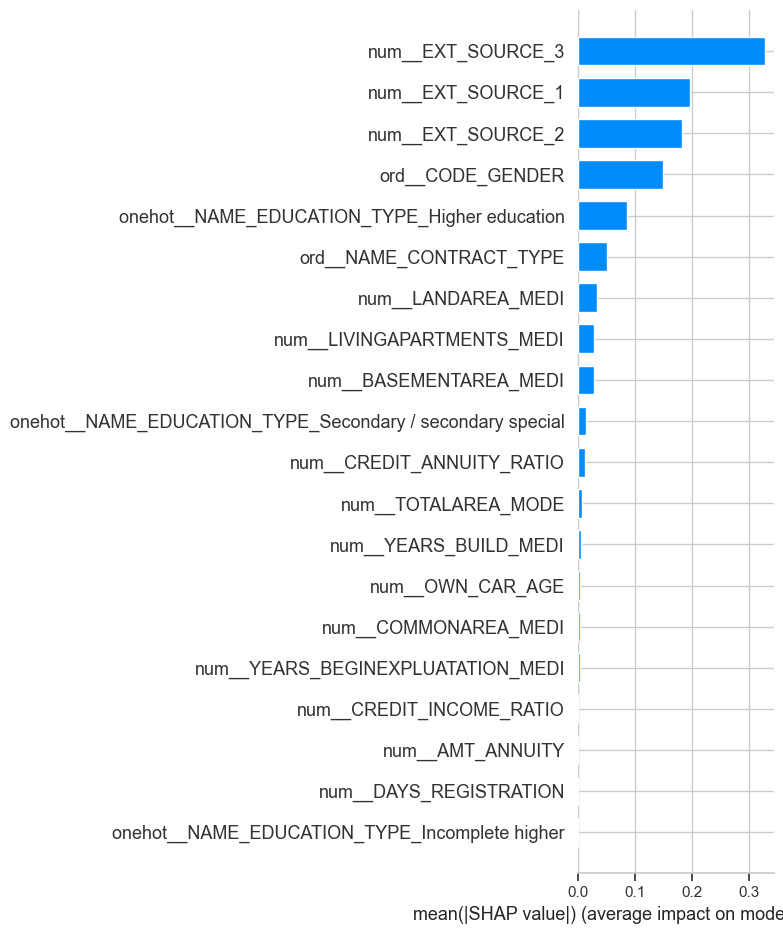

In [670]:
xgb_model = xgb_pipeline.named_steps["model"]
preprocessor = xgb_pipeline.named_steps["preprocessor"]
feature_names = preprocessor.get_feature_names_out()

explainer = shap.Explainer(xgb_model,preprocessor.transform(X_train_top_selection))
shap_values = explainer.shap_values(preprocessor.transform(X_train_top_selection))

shap.summary_plot(shap_values, preprocessor.transform(X_train_top_selection), feature_names=feature_names, plot_type="bar")

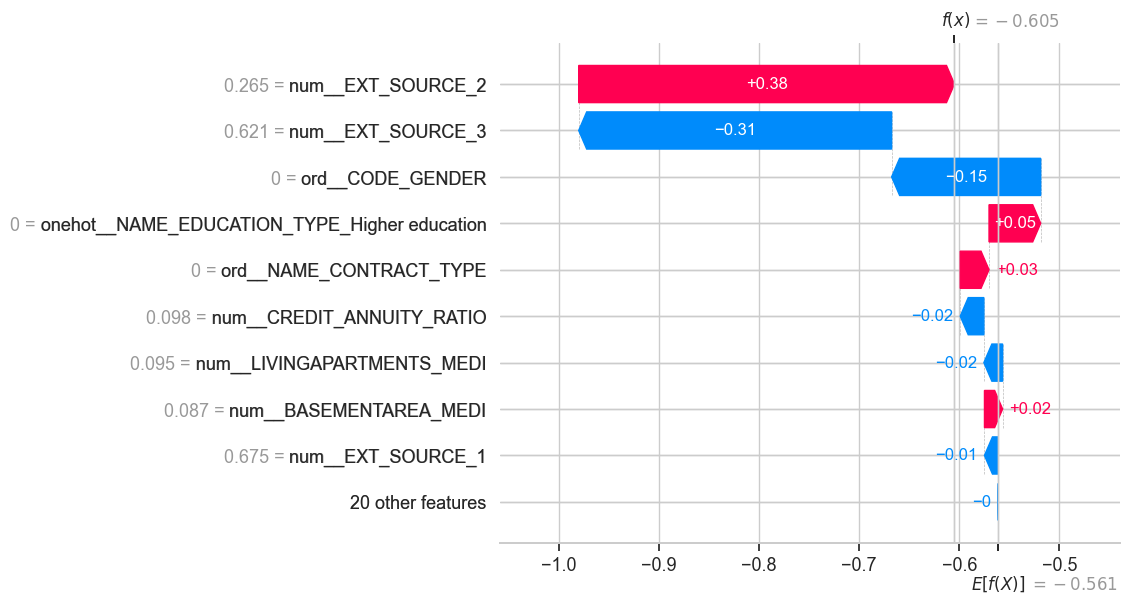

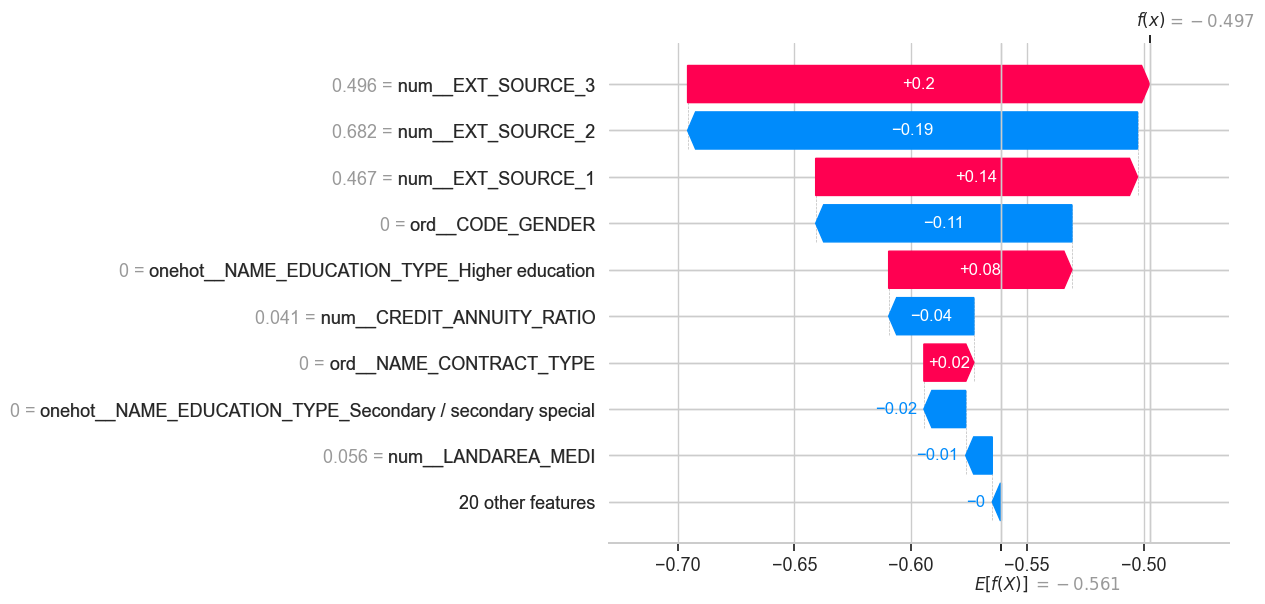

In [653]:
# Select a row where the target is 1 and a row where the target is 0
row_target_1 = X_train_top_selection[y_train == 1].iloc[0:1]
row_target_0 = X_train_top_selection[y_train == 0].iloc[0:1]

# Transform the selected rows
transformed_row_target_1 = preprocessor.transform(row_target_1)
transformed_row_target_0 = preprocessor.transform(row_target_0)

explainer = shap.Explainer(
    xgb_model,
    preprocessor.transform(X_train),
    feature_names=feature_names,
)

# Generate SHAP values for the selected rows
shap_values_target_1 = explainer(transformed_row_target_1, check_additivity=False)
shap_values_target_0 = explainer(transformed_row_target_0, check_additivity=False)

# Plot SHAP waterfall plot for the selected rows
shap.waterfall_plot(shap_values_target_1[0])
shap.waterfall_plot(shap_values_target_0[0])

100%|===================| 64575/64576 [00:32<00:00]        

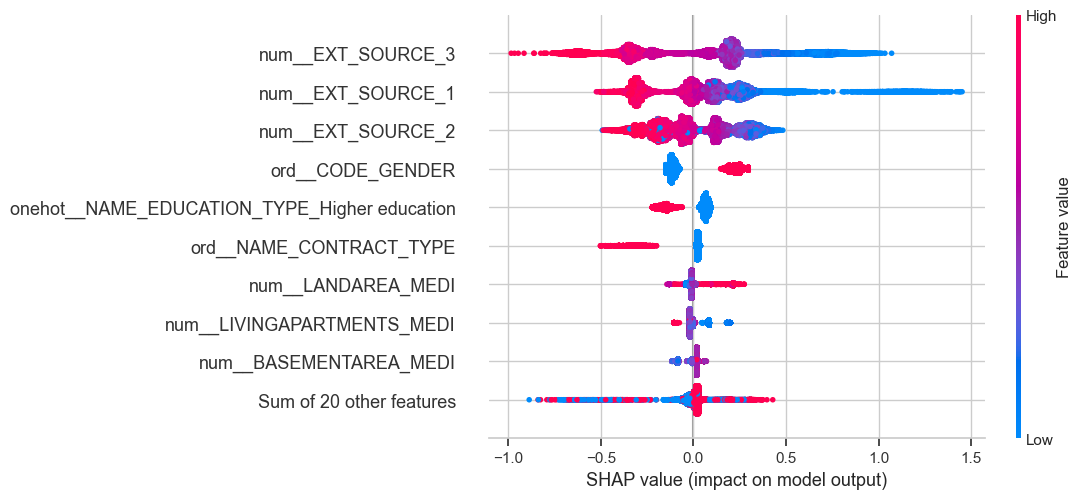

In [655]:
explainer = shap.Explainer(xgb_model, preprocessor.transform(X_train_top_selection), feature_names=feature_names)
shap_values = explainer(preprocessor.transform(X_train_top_selection))
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.beeswarm(shap_values)


In [674]:
row_target_1_preprocessed = preprocessor.transform(row_target_1)
shap_values = explainer.shap_values(row_target_1_preprocessed)

shap.force_plot(explainer.expected_value, shap_values, row_target_1_preprocessed, feature_names=feature_names)

In [1]:
row_target_0_preprocessed = preprocessor.transform(row_target_0)
shap_values = explainer.shap_values(row_target_0_preprocessed)

shap.force_plot(
    explainer.expected_value,
    shap_values,
    row_target_0_preprocessed,
    feature_names=feature_names,
)


NameError: name 'preprocessor' is not defined